In [1]:
import numpy as np
import random
from sklearn.datasets import fetch_openml

# load MNIST training and test data
mnist = fetch_openml('mnist_784', version=1, as_frame=False, cache=True)
x, y = mnist.data, mnist.target
y = y.astype(int) 
mask = (y == 3) | (y == 5)
x, y = x[mask], y[mask]
y = (y - 3)/2   # encode classes 5 as 1 and 3 as 0
x = (x - np.mean(x))/np.std(x)
N = 11552 # length of training data
x, x_test = x[0:N], x[N:len(y)]
y, y_test = y[0:N], y[N:len(y)]

# gradient of the loglikelihood function for datapoint j
def gradientsummand(q,j):
    return x[j]*(y[j] - 1/(1 + np.exp(-x[j]@q)))

# calculate accuracy of prediction 
def accuracy(q):
    likelihood = np.zeros(len(y_test))
    for j in range(len(likelihood)):
        for n in range(len(q)):
            likelihood[j] += 1/len(q)/(1 + np.exp(-x_test[j]@q[n]))
    y_predict = (likelihood > 1/2).astype(int) # predict labels for test data
    return np.mean((y_predict==y_test).astype(int)) # get accuracy

# calculate accuracy of prediction at every step of the algorithm
def accuracy_plot(q):
    accuracies = np.zeros(len(q))
    likelihood = np.zeros(len(y_test))
    for n in range(len(q)):
        for j in range(len(likelihood)):
            likelihood[j] += 1/(1 + np.exp(-x_test[j]@q[n]))
        y_predict = (likelihood/(n+1) > 1/2).astype(int) # predict labels for test data
        accuracies[n] = np.mean((y_predict==y_test).astype(int)) # get accuracy
    return accuracies 

k = len(x[0]) # get length of parameter q
sigma2 = 0.001 # sigma^2 of prior density of q

In [2]:
# stochastic gradient ascent
q_mode = np.zeros(k)
eta = 0.000001 # learning rate
m = 100 # subsample size
for n in range(100):
    Sm = np.random.choice(np.arange(0,N), size=m, replace=False) # get random sample 
    gradient_est = -1/sigma2*q_mode
    for j in Sm:
        gradient_est += N/m*gradientsummand(q_mode,j) # estimate gradient using subsample
    q_mode += eta*gradient_est # update q_mode
    
# test
print("Accuarcy using q_mode:", accuracy(np.array([q_mode])))

Accuarcy using q_mode: 0.9516298633017876


In [3]:
# SGLD
M = 100 # steps of Markov Chain
q = np.zeros((M, k))
delta = 0.00001 # step size
m = 100 # subsample size
for n in range(M-1):
    Sm = np.random.choice(np.arange(0,N), size=m, replace=False) # get random sample 
    gradient_est = -1/sigma2*q[n]
    for j in Sm:
        gradient_est += N/m*gradientsummand(q[n],j) # estimate gradient using subsample
    q[n+1] = q[n] + delta/2*gradient_est + np.random.normal(loc=0, scale=delta, size=k) # update Markov Chain

# test
print("Accuarcy using SGLD:", accuracy(q))

Accuarcy using SGLD: 0.9547844374342797


In [4]:
# calculate control variates
control_vars = np.zeros((N, k)) # control variates
sum_co_va = 0 # sum of control variates
for j in range(N):
    control_vars[j] = gradientsummand(q_mode,j)
    sum_co_va += control_vars[j]

# variance reduced SGLD
M = 100 # steps of Markov Chain
q_vr = np.zeros((M, k))
q_vr[0] = q_mode # set initial state
delta = 0.00001 # step size
m = 100 # subsample size
for n in range(M-1):
    Sm = np.random.choice(np.arange(0,N), size=m, replace=False) # get random sample 
    gradient_est = -1/sigma2*q_vr[n] + sum_co_va
    for j in Sm:
        gradient_est += N/m*(gradientsummand(q_vr[n],j) - control_vars[j]) # estimate gradient using subsample
    q_vr[n+1] = q_vr[n] + delta/2*gradient_est + np.random.normal(loc=0, scale=delta, size=k) # update Markov Chain

# test
print("Accuarcy using variance reduced SGLD:", accuracy(q_vr))

Accuarcy using variance reduced SGLD: 0.9558359621451105


In [5]:
accuracies = accuracy_plot(q) # calculate accuracies of SGLD

In [6]:
accuracies_vr = accuracy_plot(q_vr) # calculate accuracies of VRSGLD

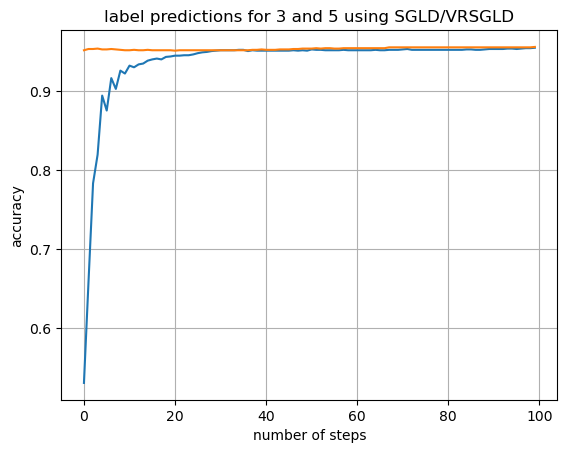

In [7]:
# create a plot of the accuracy of prediction for SGLD and VRSGLD
import matplotlib.pyplot as plt

plt.plot(np.arange(M), accuracies)
plt.plot(np.arange(M), accuracies_vr)
plt.title("label predictions for 3 and 5 using SGLD/VRSGLD")
plt.xlabel("number of steps")
plt.ylabel("accuracy")
plt.grid(True)
plt.savefig("3-5plot.pdf")
plt.show()